# Proyecto AB

Has recibido una tarea analítica de una tienda en línea internacional. Tus predecesores no consiguieron completarla: lanzaron una prueba A/B y luego abandonaron (para iniciar una granja de sandías en Brasil). Solo dejaron las especificaciones técnicas y los resultados de las pruebas.

### Descripción técnica

- Nombre de la prueba: `recommender_system_test`
- Grupos: А (control), B (nuevo embudo de pago)
- Launch date: 2020-12-07
- Fecha en la que dejaron de aceptar nuevos usuarios: 2020-12-21
- Fecha de finalización: 2021-01-01
- Audiencia: 15% de los nuevos usuarios de la región de la UE
- Propósito de la prueba: probar cambios relacionados con la introducción de un sistema de recomendaciones mejorado
- Resultado esperado: dentro de los 14 días posteriores a la inscripción, los usuarios mostrarán una mejor conversión en vistas de la página del producto (el evento `product_page`), instancias de agregar artículos al carrito de compras (`product_card`) y compras (`purchase`). En cada etapa del embudo `product_page → product_card → purchase`, habrá al menos un 10% de aumento.
- Número previsto de participantes de la prueba: 6,000


Se deben realizar las siguientes tareas:

- Describe los objetivos del estudio.
- Explora los datos:
    - ¿Es necesario convertir los tipos?
    - ¿Hay valores ausentes o duplicados? Si es así, ¿cómo los caracterizarías?
- Lleva a cabo el análisis exploratorio de datos
    - Estudia la conversión en las diferentes etapas del embudo.
    - Estudia la conversión en las diferentes etapas del embudo.
    - ¿Hay usuarios que están presentes en ambas muestras?
    - ¿Cómo se distribuye el número de eventos entre los días?
    - ¿Hay alguna peculiaridad en los datos que hay que tener en cuenta antes de iniciar la prueba A/B?
- Evaluar los resultados de la prueba A/B:
    - Evaluar los resultados de la prueba A/B:
    - Utiliza una prueba z para comprobar la diferencia estadística entre las proporciones
- Describe tus conclusiones con respecto a la etapa EDA y los resultados de la prueba A/B

In [1]:
# Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import math as mth

## Tabla de contenidos <a id='back'></a>

1. [Descarga de datos y preparación](#descarga_datos)
2. [Análisis exploratorio de datos (EDA)](#eda)
3. [Evaluación de los resultados de la prueba A/B](#resultados)
4. [Conclusiones generales y recomendaciones](#conclusiones)

## Descarga de datos y preparación <a id="descarga_datos"></a>

Vamos a cargar los datos de los siguientes datasets:

- `ab_project_marketing_events_us.csv`
- `final_ab_events_upd_us.csv`
- `final_ab_new_users_upd_us.csv`
- `final_ab_participants_upd_us.csv`

### Descarga y revision general de los datos

In [2]:
# Carga de los archivos de datos
data_marketing_events = pd.read_csv('data/ab_project_marketing_events_us.csv')
data_new_users = pd.read_csv('data/final_ab_new_users_upd_us.csv')
data_events = pd.read_csv('data/final_ab_events_upd_us.csv')
data_participants = pd.read_csv('data/final_ab_participants_upd_us.csv')

# Verificamos que se hayan cargado los datos correctamente
print(data_marketing_events.head())
print()
print(data_new_users.head())
print()
print(data_events.head())
print()
print(data_participants.head())

                           name                   regions    start_dt  \
0      Christmas&New Year Promo             EU, N.America  2020-12-25   
1  St. Valentine's Day Giveaway  EU, CIS, APAC, N.America  2020-02-14   
2        St. Patric's Day Promo             EU, N.America  2020-03-17   
3                  Easter Promo  EU, CIS, APAC, N.America  2020-04-12   
4             4th of July Promo                 N.America  2020-07-04   

    finish_dt  
0  2021-01-03  
1  2020-02-16  
2  2020-03-19  
3  2020-04-19  
4  2020-07-11  

            user_id  first_date     region   device
0  D72A72121175D8BE  2020-12-07         EU       PC
1  F1C668619DFE6E65  2020-12-07  N.America  Android
2  2E1BF1D4C37EA01F  2020-12-07         EU       PC
3  50734A22C0C63768  2020-12-07         EU   iPhone
4  E1BDDCE0DAFA2679  2020-12-07  N.America   iPhone

            user_id             event_dt event_name  details
0  E1BDDCE0DAFA2679  2020-12-07 20:22:03   purchase    99.99
1  7B6452F081F49504  2020-12-

Vamos a estudiar los datos que contiene nuestros dataset y verificar que los tipos de datos sean correctos para nuestro análisis

#### Primer dataset `data_marketing_events`

In [3]:
# Imprimimos la información general/resumen sobre nuestro dataset
data_marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


In [4]:
# Imprimos una muestra del dataset
data_marketing_events.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


Nuestro dataset `data_marketing_events` que son los datos del calendario de eventos de marketing para 2020, contiene los siguientes datos:
- `name`: nombre del evento de marketing
- `regions`: regiones donde se llevará a cabo la campaña publicitaria
- `start_dt`: fecha de inicio de la campaña
- `end_dt`: fecha de finalización de la campaña

In [5]:
# Verificamos que no haya datos duplicados en el dataset
print('Datos duplicados en la columna name del dataset:', data_marketing_events['name'].duplicated().sum())
print('Datos duplicados en el dataset:', data_marketing_events.duplicated().sum())

Datos duplicados en la columna name del dataset: 0
Datos duplicados en el dataset: 0


##### Conclusiones del dataset

Al ver la muestra y resumen del dataset, no encontramos duplicados ni ausentes. Sin embargo, vemos necesario ajustar el tipo de las columnas `start_dt` y `finish_dt` de object a datetime para poder hacer operaciones de tiempo con ellas

#### Segundo dataset `data_new_users`

In [6]:
# Imprimimos la información general/resumen sobre nuestro dataset
data_new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [7]:
# Imprimos una muestra del dataset
data_new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


Nuestro dataset `data_new_users` que son los datos de todos los usuarios que se registraron en la tienda en línea desde el 7 hasta el 21 de diciembre de 2020:
- `user_id`: id del usuario
- `first_date`: fecha de inscripción
- `region`: region a la que pertenece
- `end_dt`: dispositivo utilizado para la inscripción

In [8]:
# Verificamos que no haya datos duplicados en el dataset
print('Datos duplicados en la columna user_id del dataset:', data_new_users['user_id'].duplicated().sum())
print('Datos duplicados en el dataset:', data_new_users.duplicated().sum())

Datos duplicados en la columna user_id del dataset: 0
Datos duplicados en el dataset: 0


##### Conclusiones del dataset

Al ver la muestra y resumen del dataset, no encontramos duplicados ni ausentes. Sin embargo, vemos necesario ajustar el tipo de la columna `first_date` de object a datetime para poder hacer operaciones de tiempo con ellas

#### Tercer dataset `data_events`

In [9]:
# Imprimimos la información general/resumen sobre nuestro dataset
data_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     60314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB


In [10]:
# Imprimos una muestra del dataset
data_events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


Nuestro dataset `data_events` que son los datos de todos los eventos de los nuevos usuarios en el período comprendido entre el 7 de diciembre de 2020 y el 1 de enero de 2021:
- `user_id`: id del usuario
- `event_dt`: fecha y hora del evento
- `event_name`: nombre del tipo de evento
- `details`: datos adicionales sobre el evento (por ejemplo, el pedido total en USD para los eventos purchase)

In [11]:
# Verificamos que no haya datos duplicados en el dataset
print('Datos duplicados en el dataset:', data_events.duplicated().sum())

Datos duplicados en el dataset: 0


##### Conclusiones del dataset

Al ver la muestra y resumen del dataset, no encontramos duplicados. Sin embargo, se noto que en la columna `details` existen bastantes datos vacios; esto puede ser debido a que solo los eventos purchase generan informacion extra para details, es necesario hacer una investigación a fondo de ellos. Por último, vemos necesario ajustar el tipo de la columna `event_dt` de object a datetime para poder hacer operaciones de tiempo con ellas

#### Cuarto dataset `data_participants`

In [12]:
# Imprimimos la información general/resumen sobre nuestro dataset
data_participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB


In [13]:
# Imprimos una muestra del dataset
data_participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test


Nuestro dataset `data_participants` que son los datos de los participantes de la prueba:
- `user_id`: id del usuario
- `ab_test`: nombre de la prueba
- `group`: el grupo de prueba al que pertenecía el usuario

In [14]:
# Verificamos que no haya datos duplicados en el dataset
print('Datos duplicados en la columna user_id del dataset:', data_participants['user_id'].duplicated().sum())
print('Datos duplicados en el dataset:', data_participants.duplicated().sum())

Datos duplicados en la columna user_id del dataset: 887
Datos duplicados en el dataset: 0


##### Conclusiones del dataset

Al ver la muestra y resumen del dataset, no encontramos datos ausentes. Sin embargo, se noto que en la columna `user_id` existen 887 usuarios repetidos; esto puede ser debido a que estos usuarios participaron en otras pruebas, sin embargo es necesario investigar más a fondo.

### Preparación y procesamiento de los datos

In [15]:
## Ajustes del primer dataset

# Ajustamos las columnas start_dt y finish_dt
data_marketing_events['start_dt'] = pd.to_datetime(data_marketing_events['start_dt'])
data_marketing_events['finish_dt'] = pd.to_datetime(data_marketing_events['finish_dt'])

# Verificamos el cambio
print(data_marketing_events.info())
print()
print(data_marketing_events.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes
None

                           name                   regions   start_dt  \
0      Christmas&New Year Promo             EU, N.America 2020-12-25   
1  St. Valentine's Day Giveaway  EU, CIS, APAC, N.America 2020-02-14   
2        St. Patric's Day Promo             EU, N.America 2020-03-17   
3                  Easter Promo  EU, CIS, APAC, N.America 2020-04-12   
4             4th of July Promo                 N.America 2020-07-04   

   finish_dt  
0 2021-01-03  
1 2020-02-16  
2 2020-03-19  
3 2020-04-19  
4 2020-07-11  


In [16]:
## Ajustes del segundo dataset

# Ajustamos las columnas first_date
data_new_users['first_date'] = pd.to_datetime(data_new_users['first_date'])

# Verificamos el cambio
print(data_new_users.info())
print()
print(data_new_users.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     58703 non-null  object        
 1   first_date  58703 non-null  datetime64[ns]
 2   region      58703 non-null  object        
 3   device      58703 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.8+ MB
None

            user_id first_date     region   device
0  D72A72121175D8BE 2020-12-07         EU       PC
1  F1C668619DFE6E65 2020-12-07  N.America  Android
2  2E1BF1D4C37EA01F 2020-12-07         EU       PC
3  50734A22C0C63768 2020-12-07         EU   iPhone
4  E1BDDCE0DAFA2679 2020-12-07  N.America   iPhone


In [17]:
## Ajustes del tercer dataset

# Verificamos los datos ausentes de la columna details con la columna event_name
# Vemos las diferentes opciones que tiene event_name
print(data_events['event_name'].unique())
# Verificamos si las diferentes opciones tiene datos vacios en la columna details
data_events.groupby('event_name')['details'].count()

['purchase' 'product_cart' 'product_page' 'login']


event_name
login               0
product_cart        0
product_page        0
purchase        60314
Name: details, dtype: int64

Como podemos ver, el evento purchase es el unico que tiene datos en `details`, los demás eventos no necesitan agregar detalles. Una vez verificado esto, podemos dejar los datos vacios ya que no afectara a los calculos de nuestra columna.

In [18]:
# Ajustamos las columnas event_dt
data_events['event_dt'] = pd.to_datetime(data_events['event_dt'])

# Verificamos el cambio
print(data_events.info())
print()
print(data_events.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     423761 non-null  object        
 1   event_dt    423761 non-null  datetime64[ns]
 2   event_name  423761 non-null  object        
 3   details     60314 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 12.9+ MB
None

            user_id            event_dt event_name  details
0  E1BDDCE0DAFA2679 2020-12-07 20:22:03   purchase    99.99
1  7B6452F081F49504 2020-12-07 09:22:53   purchase     9.99
2  9CD9F34546DF254C 2020-12-07 12:59:29   purchase     4.99
3  96F27A054B191457 2020-12-07 04:02:40   purchase     4.99
4  1FD7660FDF94CA1F 2020-12-07 10:15:09   purchase     4.99


In [19]:
## Ajustes del cuarto dataset

# Verificamos los datos duplicados en user_id
# Agrupamos los usuarios con más de un grupo
print('Usuarios con más de 1 grupo: ', data_participants.groupby('user_id')['group'].nunique().reset_index().query('group > 1').size)
# Agrupamos los usuarios con más de una prueba
print('Usuarios con más de 1 prueba: ', data_participants.groupby('user_id')['ab_test'].nunique().reset_index().query('ab_test > 1').size)

Usuarios con más de 1 grupo:  882
Usuarios con más de 1 prueba:  1774


In [20]:
# Vemos los nombres unicos de las pruebas
data_participants['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

Como podemos observar, tenemos 882 usuarios con más de un grupo y 1774 usuarios que estan en 2 pruebas diferentes. Al ver los nombres únicos de las pruebas, vemos que hay 2 tipos de pruebas en los resultados. A continuacion pasaremos a filtrar los usuarios por la prueba que nos corresponde y veremos si eso elimina los duplicados

In [21]:
# Seleccionamos los usuarios del test y guardamos el dataset original
data_participants_original = data_participants
data_participants = data_participants.query("ab_test == 'recommender_system_test'")
# Agrupamos los usuarios con más de un grupo
print('Usuarios con más de 1 grupo: ', data_participants.groupby('user_id')['group'].nunique().reset_index().query('group > 1').size)
# Agrupamos los usuarios con más de una prueba
print('Usuarios con más de 1 prueba: ', data_participants.groupby('user_id')['ab_test'].nunique().reset_index().query('ab_test > 1').size)

Usuarios con más de 1 grupo:  0
Usuarios con más de 1 prueba:  0


Se logro eliminar los duplicados con este filtrado.

Hemos terminado de procesar cada uno de los datasets y estamos listos para pasar a la siguiente fase.

## Análisis Exploratorio de datos (EDA)

Para esta fase debemos responder realizar y responder los siguientes puntos y preguntas

- Estudia la conversión en las diferentes etapas del embudo.
- ¿El número de eventos por usuario está distribuido equitativamente entre las muestras?
- ¿Hay usuarios que están presentes en ambas muestras?
- ¿Cómo se distribuye el número de eventos entre los días?
- ¿Hay alguna peculiaridad en los datos que hay que tener en cuenta antes de iniciar la prueba A/B?

### Estudia la conversión en las diferentes etapas del embudo

In [22]:
## Dividimos los usuarios en sus grupos para ver su conversion especifica
# Juntamos los datasets para tener la relacion de usuarios que participaron en la prueba y sus grupos
data_events_participants = data_events.merge(data_participants, how='inner', on='user_id')
print('Numero de eventos de las personas participantes en la prueba:', data_events_participants.shape[0])
print('Numero de eventos totales:', data_events.shape[0])

Numero de eventos de las personas participantes en la prueba: 23909
Numero de eventos totales: 423761


In [23]:
# Calculamos la cantidad de usuarios que realizaron cada uno de los eventos participantes del grupo B
event_user = data_events_participants.groupby('event_name')['user_id'].nunique().reset_index()
event_user['event_name']= pd.Categorical(event_user.event_name,categories=['login', 'product_page', 'product_cart', 'purchase'])
event_user=event_user.sort_values('event_name')
usuarios_totales = data_events_participants['user_id'].nunique()
event_user['% of total users'] = event_user['user_id'] / usuarios_totales
event_user['% of total users'] = event_user['% of total users'].map("{:.2%}".format)
event_user

,event_name,user_id,% of total users
0,login,3674,99.97%
2,product_page,2303,62.67%
1,product_cart,1079,29.36%
3,purchase,1128,30.69%


In [24]:
# Seleccionamos la data para el embudo
evento_embudo = event_user[['event_name', 'user_id']]
# Guardamos los usuarios iniciales
usuarios_iniciales = event_user.loc[0:0]['user_id'].max()
# Calculamos la primera conversion
evento_embudo['Conversion'] = evento_embudo['user_id'] / usuarios_iniciales
# Calculamos la conversion a la siguiente etapa
first_data = data_events_participants.groupby('event_name')['user_id'].nunique().reset_index()
first_data['event_name']= pd.Categorical(first_data.event_name,categories=['login', 'product_page', 'product_cart', 'purchase'])
first_data=first_data.sort_values('event_name').groupby('event_name').sum()
evento_embudo = evento_embudo.merge(first_data.shift(1).reset_index().fillna(evento_embudo.loc[0:0]), on='event_name')
evento_embudo['Conversion a la siguiente etapa'] = evento_embudo['user_id_x'] / evento_embudo['user_id_y']
# Le damos formato a los datos y seleccionamos las columnas
evento_embudo['Conversion'] = evento_embudo['Conversion'].map("{:.2%}".format)
evento_embudo['Conversion a la siguiente etapa'] = evento_embudo['Conversion a la siguiente etapa'].map("{:.2%}".format)
evento_embudo_final = evento_embudo[['event_name', 'user_id_x', 'Conversion', 'Conversion a la siguiente etapa']]
evento_embudo_final

,event_name,user_id_x,Conversion,Conversion a la siguiente etapa
0,login,3674,100.00%,100.00%
1,product_page,2303,62.68%,62.68%
2,product_cart,1079,29.37%,46.85%
3,purchase,1128,30.70%,104.54%


#### Grupo A

In [25]:
# Calculamos la cantidad de usuarios que realizaron cada uno de los eventos participantes del grupo B
event_user = data_events_participants.query("group == 'A'").groupby('event_name')['user_id'].nunique().reset_index()
event_user['event_name']= pd.Categorical(event_user.event_name,categories=['login', 'product_page', 'product_cart', 'purchase'])
event_user=event_user.sort_values('event_name')
usuarios_totales = data_events_participants.query("group == 'A'")['user_id'].nunique()
event_user['% of total users'] = event_user['user_id'] / usuarios_totales
event_user['% of total users'] = event_user['% of total users'].map("{:.2%}".format)
event_user

,event_name,user_id,% of total users
0,login,2747,100.00%
2,product_page,1780,64.80%
1,product_cart,824,30.00%
3,purchase,872,31.74%


In [26]:
# Seleccionamos la data para el embudo
evento_embudo = event_user[['event_name', 'user_id']]
# Guardamos los usuarios iniciales
usuarios_iniciales = event_user.loc[0:0]['user_id'].max()
# Calculamos la primera conversion
evento_embudo['Conversion'] = evento_embudo['user_id'] / usuarios_iniciales
# Calculamos la conversion a la siguiente etapa
first_data = data_events_participants.query("group == 'A'").groupby('event_name')['user_id'].nunique().reset_index()
first_data['event_name']= pd.Categorical(first_data.event_name,categories=['login', 'product_page', 'product_cart', 'purchase'])
first_data=first_data.sort_values('event_name').groupby('event_name').sum()
evento_embudo = evento_embudo.merge(first_data.shift(1).reset_index().fillna(evento_embudo.loc[0:0]), on='event_name')
evento_embudo['Conversion a la siguiente etapa'] = evento_embudo['user_id_x'] / evento_embudo['user_id_y']
# Le damos formato a los datos y seleccionamos las columnas
evento_embudo['Conversion'] = evento_embudo['Conversion'].map("{:.2%}".format)
evento_embudo['Conversion a la siguiente etapa'] = evento_embudo['Conversion a la siguiente etapa'].map("{:.2%}".format)
evento_embudo_final = evento_embudo[['event_name', 'user_id_x', 'Conversion', 'Conversion a la siguiente etapa']]
evento_embudo_final

,event_name,user_id_x,Conversion,Conversion a la siguiente etapa
0,login,2747,100.00%,100.00%
1,product_page,1780,64.80%,64.80%
2,product_cart,824,30.00%,46.29%
3,purchase,872,31.74%,105.83%


#### Grupo B

In [27]:
# Calculamos la cantidad de usuarios que realizaron cada uno de los eventos participantes del grupo B
event_user = data_events_participants.query("group == 'B'").groupby('event_name')['user_id'].nunique().reset_index()
event_user['event_name']= pd.Categorical(event_user.event_name,categories=['login', 'product_page', 'product_cart', 'purchase'])
event_user=event_user.sort_values('event_name')
usuarios_totales = data_events_participants.query("group == 'B'")['user_id'].nunique()
event_user['% of total users'] = event_user['user_id'] / usuarios_totales
event_user['% of total users'] = event_user['% of total users'].map("{:.2%}".format)
event_user

,event_name,user_id,% of total users
0,login,927,99.89%
2,product_page,523,56.36%
1,product_cart,255,27.48%
3,purchase,256,27.59%


In [28]:
# Seleccionamos la data para el embudo
evento_embudo = event_user[['event_name', 'user_id']]
# Guardamos los usuarios iniciales
usuarios_iniciales = event_user.loc[0:0]['user_id'].max()
# Calculamos la primera conversion
evento_embudo['Conversion'] = evento_embudo['user_id'] / usuarios_iniciales
# Calculamos la conversion a la siguiente etapa
first_data = data_events_participants.query("group == 'B'").groupby('event_name')['user_id'].nunique().reset_index()
first_data['event_name']= pd.Categorical(first_data.event_name,categories=['login', 'product_page', 'product_cart', 'purchase'])
first_data=first_data.sort_values('event_name').groupby('event_name').sum()
evento_embudo = evento_embudo.merge(first_data.shift(1).reset_index().fillna(evento_embudo.loc[0:0]), on='event_name')
evento_embudo['Conversion a la siguiente etapa'] = evento_embudo['user_id_x'] / evento_embudo['user_id_y']
# Le damos formato a los datos y seleccionamos las columnas
evento_embudo['Conversion'] = evento_embudo['Conversion'].map("{:.2%}".format)
evento_embudo['Conversion a la siguiente etapa'] = evento_embudo['Conversion a la siguiente etapa'].map("{:.2%}".format)
evento_embudo_final = evento_embudo[['event_name', 'user_id_x', 'Conversion', 'Conversion a la siguiente etapa']]
evento_embudo_final

,event_name,user_id_x,Conversion,Conversion a la siguiente etapa
0,login,927,100.00%,100.00%
1,product_page,523,56.42%,56.42%
2,product_cart,255,27.51%,48.76%
3,purchase,256,27.62%,100.39%


En primera instancia, podemos ver que solo 23,909 eventos del total de 423,761 son de los usuarios participantes en la prueba, por lo que nuestra muestra bajo considerablemente. Viendo los datos pudimos notar que en general y dividido en los grupos de la prueba que tenemos más eventos de purchase que de product_cart (un diferencia minima sin embargo es algo destacable), lo cual nos indica que o hay una opcion para comprar directamente sin pasar a agregar al carrito o el sistema no esta catalogando bien los eventos finales del funnel.

En general podemos ver que la conversion de la product_page al carrito es de 46-48% y entre la product_cart y el purchase hay una conversion superior al 100% por en un maximo de 5% más. En general de las personas logeadas un promedio del 60% llega a ver la product_page y un 30% llega a agregar un producto o hacer una compra.

### ¿El número de eventos por usuario está distribuido equitativamente entre las muestras?

In [29]:
# Número de eventos por grupo
data_events_participants.groupby(['group', 'user_id'])['event_name'].count().reset_index().groupby('group').sum()

,event_name
group,
A,18627
B,5282


In [30]:
# Numero de usuarios por grupo
data_events_participants.groupby(['group'])['user_id'].nunique()

group
A    2747
B     928
Name: user_id, dtype: int64

In [31]:
# Número de eventos de promedio por persona en cada grupo
data_events_participants.groupby(['group', 'user_id'])['event_name'].count().reset_index().groupby('group').mean()

,event_name
group,
A,6.780852
B,5.691810


Como podemos notar al inicio, el grupo A tiene mas eventos que el grupo B sin embargo el numero de eventos por usuario promedio no es tan diferente, difiere en uno. Tomando todo esto en cuenta podemos decir que no esta distribuido equitativamente pero la diferencia por usuario es minima.

### ¿Hay usuarios que están presentes en ambas muestras?

In [32]:
# Agrupamos los usuarios con más de un grupo
print('Usuarios con más de 1 grupo: ', data_participants.groupby('user_id')['group'].nunique().reset_index().query('group > 1').size)

Usuarios con más de 1 grupo:  0


Gracias a la limpieza que hicimos, cada usuario tiene solo un grupo asignado. Sin duplicados.

### ¿Cómo se distribuye el número de eventos entre los días?

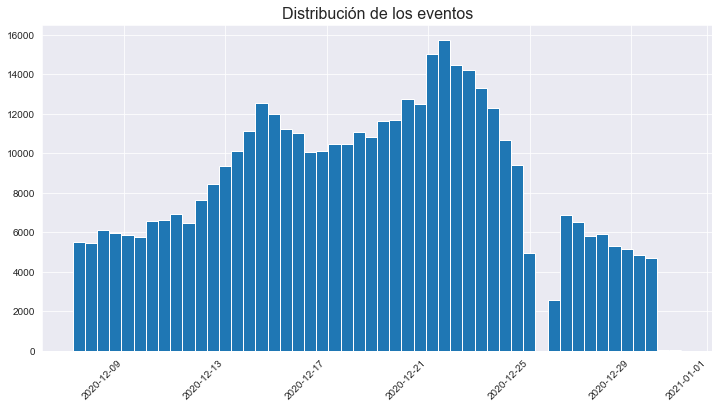

In [33]:
# Trazamos un histograma de los eventos
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(data_events['event_dt'], bins=50)
plt.xticks(rotation=45,ha='right')
plt.title('Distribución de los eventos',fontsize=16)
plt.show()

Como podemos observar en la grafica, los eventos tienen una subida entre el 13 y el 17 de diciembre para luego estabilizarse los siguientes dias, hasta el dia 21 donde empieza otra subida que posteriormente empieza a bajar hasta cesar toda actividad el dia 25 de diciembre, posterior a esto vuelve a haber actividad relativamente baja hacia el fin del año

### ¿Hay alguna peculiaridad en los datos que hay que tener en cuenta antes de iniciar la prueba A/B?

Como pudimos notar en el punto anterior no hubo actividad el dia 25 de diciembre, no se registro ningun evento ese dia por lo que tendra que tomarse en cuenta posteriormente. Tambien se debe tomar en cuenta que hay mayor numero de usuarios en el grupo A que en el B y por ende mayor numero de eventos, además de que de los 6,000 usuarios esperados solo participaron menos de 4,000; finalmente tambien se debe tomar en cuenta que hay mas eventos en la categoria purchase que en product_cart por lo que el funnel puede no estar del todo bien agrupado o dividio o se permite comprar sin pasar por el carrito de compras

## Evaluación de los resultados de la prueba A/B

Para esta fase debemos responder realizar y responder los siguientes puntos y preguntas

- ¿Qué puedes decir sobre los resultados de la prueba A/B?
- Utiliza una prueba z para comprobar la diferencia estadística entre las proporciones.

In [34]:
## Calcular la conversion para cada grupo y representarla graficamente
# Crear una matriz con valores únicos de parejas fecha-grupo
data_events_participants['date'] = pd.DatetimeIndex(data_events_participants['event_dt']).date
dates_groups = data_events_participants[['date','group']].drop_duplicates()
dates_groups

,date,group
0,2020-12-07,A
1,2020-12-09,A
3,2020-12-08,A
11,2020-12-07,B
12,2020-12-09,B
13,2020-12-11,B
14,2020-12-12,B
15,2020-12-16,B
27,2020-12-12,A
28,2020-12-22,A


In [35]:
# Dividimos con dummies nuestros events_name para poder analizarlos
data_events_participants_divided = pd.get_dummies(data_events_participants, columns=['event_name'])
data_events_participants_divided

# Obtenemos los datos diarios acumulados agregados sobre los pedidos
events_aggregated = dates_groups.apply(lambda x: data_events_participants_divided[np.logical_and(data_events_participants_divided['date'] <= x['date'], data_events_participants_divided['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'user_id' : pd.Series.nunique, 'event_name_login' : 'sum', 'event_name_product_page' : 'sum', 'event_name_product_cart' : 'sum', 'event_name_purchase' : 'sum'}), axis=1).sort_values(by=['date','group'])
events_aggregated

,date,group,user_id,event_name_login,event_name_product_page,event_name_product_cart,event_name_purchase
0,2020-12-07,A,154,154,96,35,46
11,2020-12-07,B,173,165,108,46,59
3,2020-12-08,A,256,313,204,72,83
65,2020-12-08,B,220,284,172,80,94
1,2020-12-09,A,340,491,310,122,134
12,2020-12-09,B,308,456,278,123,134
137,2020-12-10,A,407,656,404,167,180
66,2020-12-10,B,341,587,350,157,160
185,2020-12-11,A,500,841,506,212,222
13,2020-12-11,B,362,676,396,174,176


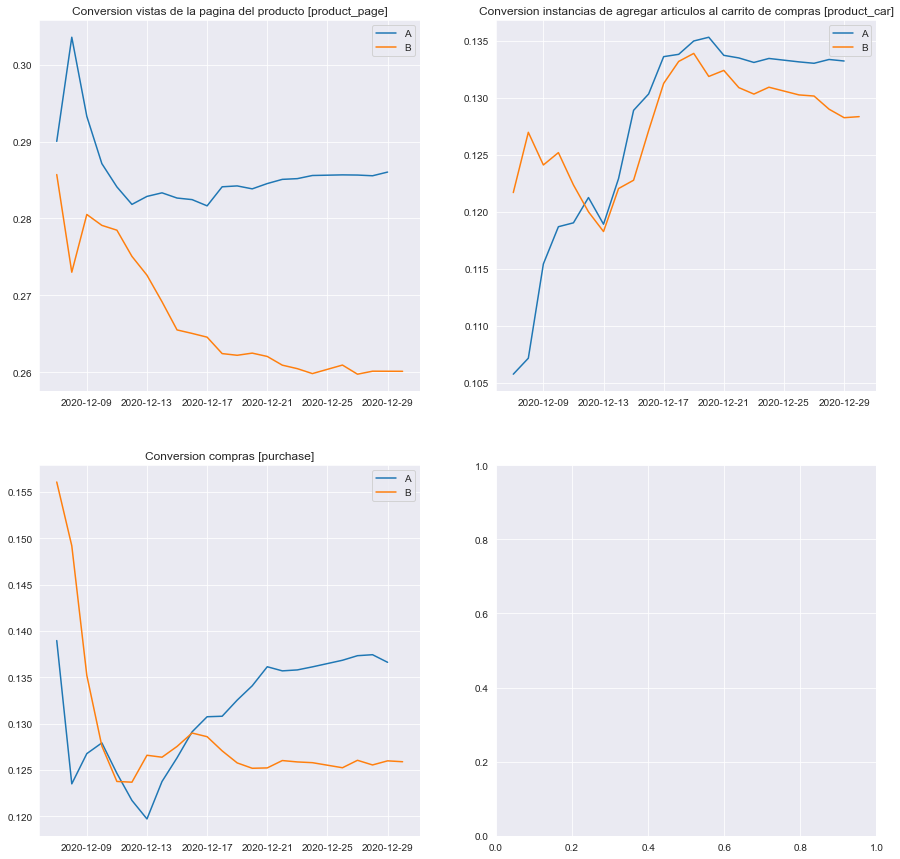

In [36]:
# Calculamos la conversión acumulada para cada evento
events_aggregated['total_events'] = events_aggregated['event_name_login'] + events_aggregated['event_name_product_page'] + events_aggregated['event_name_product_cart'] + events_aggregated['event_name_purchase']
events_aggregated['conversion_product_page'] = events_aggregated['event_name_product_page'] / events_aggregated['total_events']
events_aggregated['conversion_product_cart'] = events_aggregated['event_name_product_cart'] / events_aggregated['total_events']
events_aggregated['conversion_purchase'] = events_aggregated['event_name_purchase'] / events_aggregated['total_events']

# Seleccionar datos en el grupo A
cumulative_data_a = events_aggregated[events_aggregated['group']=='A']

# Seleccionar datos en el grupo B
cumulative_data_b = events_aggregated[events_aggregated['group']=='B']

# Subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

# Trazar los gráficos
axes[0,0].plot(cumulative_data_a['date'], cumulative_data_a['conversion_product_page'], label='A')
axes[0,0].plot(cumulative_data_b['date'], cumulative_data_b['conversion_product_page'], label='B')
axes[0,0].legend()
axes[0,0].set_title("Conversion vistas de la pagina del producto [product_page]")
axes[0,1].plot(cumulative_data_a['date'], cumulative_data_a['conversion_product_cart'], label='A')
axes[0,1].plot(cumulative_data_b['date'], cumulative_data_b['conversion_product_cart'], label='B')
axes[0,1].legend()
axes[0,1].set_title("Conversion instancias de agregar articulos al carrito de compras [product_car]")
axes[1,0].plot(cumulative_data_a['date'], cumulative_data_a['conversion_purchase'], label='A')
axes[1,0].plot(cumulative_data_b['date'], cumulative_data_b['conversion_purchase'], label='B')
axes[1,0].set_title("Conversion compras [purchase]")
axes[1,0].legend()

Analizadas las graficas podemos notar lo siguiente:

- La conversion de las personas que ven la pagina del producto empezo relativamente similiar en ambos grupos, sin embargo el grupo B empezo a decaer drasticamente mientras que el A crecio tambien drasticamente ocasionando una diferencia en la conversion de ambos grupos de 0.3 o 3% al final de la prueba
- La conversion de las personas a agregar articulos al carrito empezo con una diferencia entre los grupos siendo el grupo B el que mayor conversion tenia, sin embargo el grupo A fue gananado conversion hasta que al final se tuvo una diferencia en promedio de 0.005 o 0.5%, siendo el grupo A el que mejor conversion tuvo en este evento
- La conversion de productos comprados empezo relativamente alta teniendo un 0.15 para el grubo B pero empezo a decaer para ambos grupos, aunque el grupo A empezo a crecer conforme pasaban los dias mientras que el B solo se estabilizo, resultando en una diferencia de 0.010 o 1%, quedando el grupo A como el que mejor conversion logro.

In [37]:
events_by_user = data_events_participants_divided.groupby('group', as_index=False).agg(({'event_name_login' : 'sum', 'event_name_product_page' : 'sum', 'event_name_product_cart' : 'sum', 'event_name_purchase' : 'sum'}))
events_by_user['total_funnel_events'] = events_by_user['event_name_login'] + events_by_user['event_name_product_page'] + events_by_user['event_name_product_cart'] + events_by_user['event_name_purchase']
events_by_user_a = events_by_user.query("group == 'A'")
events_by_user_b = events_by_user.query("group == 'B'")

def stadistic_difference_conversion(alpha, metric, event):

    metrics = np.array([events_by_user_a[metric], events_by_user_b[metric]])
    events = np.array([events_by_user_a[event], events_by_user_b[event]])

    print(metrics)
    print(events)

    # proporción de éxito del grupo de a
    p1 = metrics[0] / events[0]

    # proporción de éxito del grupo b
    p2 = metrics[1] / events[1]

    # proporción de éxito en el dataset unido:
    p_combined = (metrics[0] + metrics[1]) / (events[0] + events[1])

    # la diferencia entre las proporciones de los datasets
    difference = p1 - p2

    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/events[0] + 1/events[1]))

    # establece la distribución normal estándar (media 0, desviación estándar 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print("Conversion de total de eventos a", metric)
    print('p-value: ', p_value)
    print(p2-p1 * 100)

    if p_value < alpha: # escribe tu código aquí
        print("Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones")
    else:
        print("No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes")

In [38]:
# Calculamos la diferencia estadistica para el evento product_page
stadistic_difference_conversion(0.05, "event_name_product_page", "total_funnel_events")
print()
# Calculamos la diferencia estadistica para el evento product_cart
stadistic_difference_conversion(0.05, "event_name_product_cart", "total_funnel_events")
print()
# Calculamos la diferencia estadistica para el evento purchase
stadistic_difference_conversion(0.05, "event_name_purchase", "total_funnel_events")

[[5328.]
 [1374.]]
[[18627.]
 [ 5282.]]
Conversion de total de eventos a event_name_product_page
p-value:  [0.00021543]
[-28.34351114]
Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones

[[2482.]
 [ 678.]]
[[18627.]
 [ 5282.]]
Conversion de total de eventos a event_name_product_cart
p-value:  [0.35462587]
[-13.19638318]
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes

[[2545.]
 [ 665.]]
[[18627.]
 [ 5282.]]
Conversion de total de eventos a event_name_purchase
p-value:  [0.04348652]
[-13.53706309]
Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones


Podemos dar las siguientes conclusiones:

- Para el evento product_page podemos ver que hay una diferencia significativa entre las propociones de los grupos, en el cual la conversion del grupo B fue 28.34% menor relativamente a la del grupo A
- Para el evento product_car no se detecto una diferencia significativa entre las propociones de los grupos, sin embargo la conversion del grupo B fue 13.19% menor relativamente a la del grupo A
- Para el evento purchase podemos ver que hay una diferencia significativa entre las propociones de los grupos, en el cual la conversion del grupo B fue 13.53% menor relativamente a la del grupo A

## Conclusiones generales y recomendaciones

Describe tus conclusiones con respecto a la etapa EDA y los resultados de la prueba A/B.

En general pudimos notar que la prueba de no fue del todo bien implementado y por ende sus resultados podrian estar afectados, esto debido a los siguientes factores:

- Aunque el numero de eventos por usuario tenia diferencias minimas en su distribucion, es notable que el numero de usuarios en el grupo A era muy superior al grupo B y por ende su numero de eventos.
- De los 6,000 usuarios esperados para participar, solo participaron cerca de 4,000 usuarios
- Se detecto que el evento ultimo del funnel tenia mas eventos que su antecesor, esto no deberia pasar y nos indica que hay formas que los usuarios hagan una compra sin pasar por el carrito de compras y por lo tanto el funnel no esta bien definido o hubo un problema en la clasificacion de estos eventos que ocasiono que esta situacion pasara
- Las fechas de la prueba no fue la más acorde debido a que colindaba con fechas de fiestas (Navidad y Año Nuevo) por lo que los datos podrian sesgarse y no revelar el verdadero comportamiento de los usuarios, ademas de que se tuvo un paron en los eventos el dia 25 y podrian haber afectado los resultados.

Los resultados finales de la prueba, no nos reflejaron el resultado esperado ya que:

- Para el evento de `product_page`, la conversion del grupo expuesto tuvo una diferencia significativa con el control pero negativa, ya que este grupo expuesto reporto una conversion 28.34% menor a la del grupo control
- Para el evento de `product_car`, la conversion del grupo expuesto no tuvo una diferencia significativa con el control, sin embargo se tuvo una baja relativa de 13.19% respecto al control
- Para el evento de `purchase`, la conversion del grupo expuesto tuvo una diferencia significativa con el control pero negativa, ya que este grupo expuesto reporto una conversion 13.53% menor a la del grupo control

Debido a estos resultados, la prueba se considera fallida. A pesar de ello, como comentamos al inicio es posible que todas las anomalias encontradas en las pruebas hayan ocasionado estos resultados negativos, por lo que se recomienda realizar una segunda prueba pero asegurandose de cumplir todos los pre-requisitos y cumpliendo bien con los parametros o realizar una nueva hipotesis que pueda ayudarnos a aumentar la conversion con el KPI buscado.